In [1]:
# | ------------------------|
# | TODO !!!!!!!!!!!!!!!!!!!|
# | TODO: fix bandpasses !!!|  <- isn't really a problem
# | TODO !!!!!!!!!!!!!!!!!!!|
# | ------------------------|
from math import pi
from pathlib import Path

import pyro
import torch
from matplotlib import pyplot as plt
from torch import Tensor

torch.set_default_tensor_type(torch.cuda.FloatTensor)
from clipppy.patches import torch_numpy

from lib.bayesn import get_conditioning, get_mock_trace, get_truths, load, Model


N = 100
DATA_GEN = f'{N}-redshift'
GUIDE_KEY = 'hpmvn'
CONDITION_KEY = ''
SUFFIX = ''  # '-negrenyi'

EXPERIMENT_NAME = '-'.join((_ for _ in (GUIDE_KEY, CONDITION_KEY) if _))
SAVENAME = f'{EXPERIMENT_NAME}{SUFFIX}'
RESDIR = Path(f'res-{DATA_GEN}')

guidename = RESDIR / f'{SAVENAME}-guide.pt'
lossesname = RESDIR / f'{SAVENAME}-losses.pt'

GEN = True
config = load(EXPERIMENT_NAME, DATA_GEN, N, gen=GEN)

lc: Model = config.kwargs['defs']['model']
times: Tensor = config.kwargs['defs']['times']
filters: Tensor = config.kwargs['defs']['filters']

if not GEN:
    trace = get_mock_trace(config)
    truths = get_truths(config)

In [ ]:
config.conditioning = {'obs': truths['obs']} | get_conditioning(config, CONDITION_KEY)

### Fit

In [3]:
from collections import defaultdict


losses = []
config.guide.model = config.model
config.guide.setup(init={
    'Av': torch.ones_like(truths['Av']) * 0.01,
    'delta_M': torch.zeros_like(truths['delta_M']),
    **{
        key: truths[key] + defaultdict(lambda: 0.1, Om0=0, Ode0=0)[key]
        for key in ('Om0', 'Ode0', 'Rv', 'tau', 'W', 'W0', 'theta')
    }
})
config.guide

/home/kosio/Projects/Python/pyrofit-utils/pyrofit/utils/interpolate/abc.py:34: UserWarning: input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible (Triggered internally at  /build/python-pytorch/src/pytorch-1.9.1-opt-cuda/aten/src/ATen/native/BucketizationUtils.h:19.)
  return searchsorted(*broadcast_except(grid, x, dim=-1), right=True).clamp_(1, grid.shape[-1]-1).sub_(1)


Guide(
  (hpmvn): HierarchicPartialMultivariateNormalSamplingGroup(8 sites, torch.Size([1505]))
)

In [5]:
from clipppy.utils import Sentinel
from pyro.infer import RenyiELBO, Trace_ELBO


# MVN:
# sched = (1e-2, 10000), (1e-3, 2000), (1e-3, 3000), (1e-2, 2000), (1e-3, 10000), (1e-4, 10000)
# others:
sched = (
    # (1e-2, 10000), (1e-3, 2000), (1e-3, 3000),
    (1e-2, 2000), (1e-3, 10000), (1e-4, 2000),
    (1e-3, 2000), (1e-4, 2000), (1e-5, 2000),
)

loss_cls = RenyiELBO(alpha=-10, num_particles=1) if SUFFIX.endswith('renyi') else Trace_ELBO()
print(SAVENAME, loss_cls)
for lr, n_steps in sched:
    losses += config.fit(
        lr=lr, n_steps=n_steps,
        loss_cls=loss_cls, loss_args=Sentinel.no_call)

hpmvn <pyro.infer.trace_elbo.Trace_ELBO object at 0x7fac60155070>


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:
torch.save(config.guide, guidename)
torch.save(losses, lossesname)

### Plot

In [ ]:
config.guide = torch.load(guidename)
losses = torch.load(lossesname)
config.guide

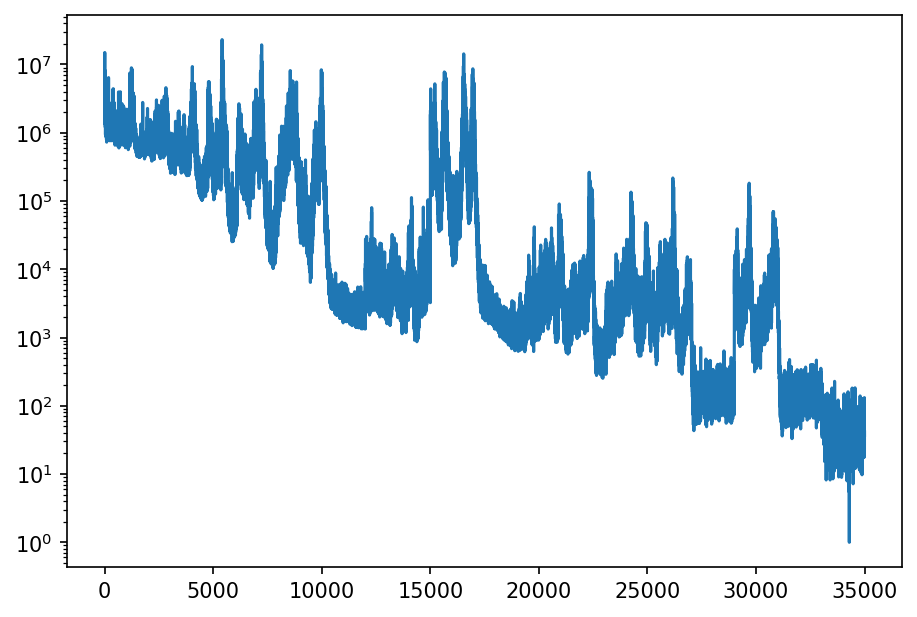

In [7]:
plt.semilogy(torch.tensor(losses)-min(losses) + 1);

In [8]:
import numpy as np

with pyro.plate('plate', 1000):
    ppd = config.guide()

names = 'Om0', 'Ode0', 'Rv', 'tau', 'delta_M/scale', 'Av', 'delta_M', 'theta'
x = torch.cat([(val if val.ndim >= 2 else val.unsqueeze(-1)).flatten(1)
               for name in names for val in [ppd[name]]], dim=-1)
C = np.corrcoef(x.T)

nfull = 5
nhier = 3
names_full = names[:nfull]
names_hier = names[-nhier:]

In [20]:
DOSAVE = False

/usr/lib/python3.9/site-packages/corner/core.py:103: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(


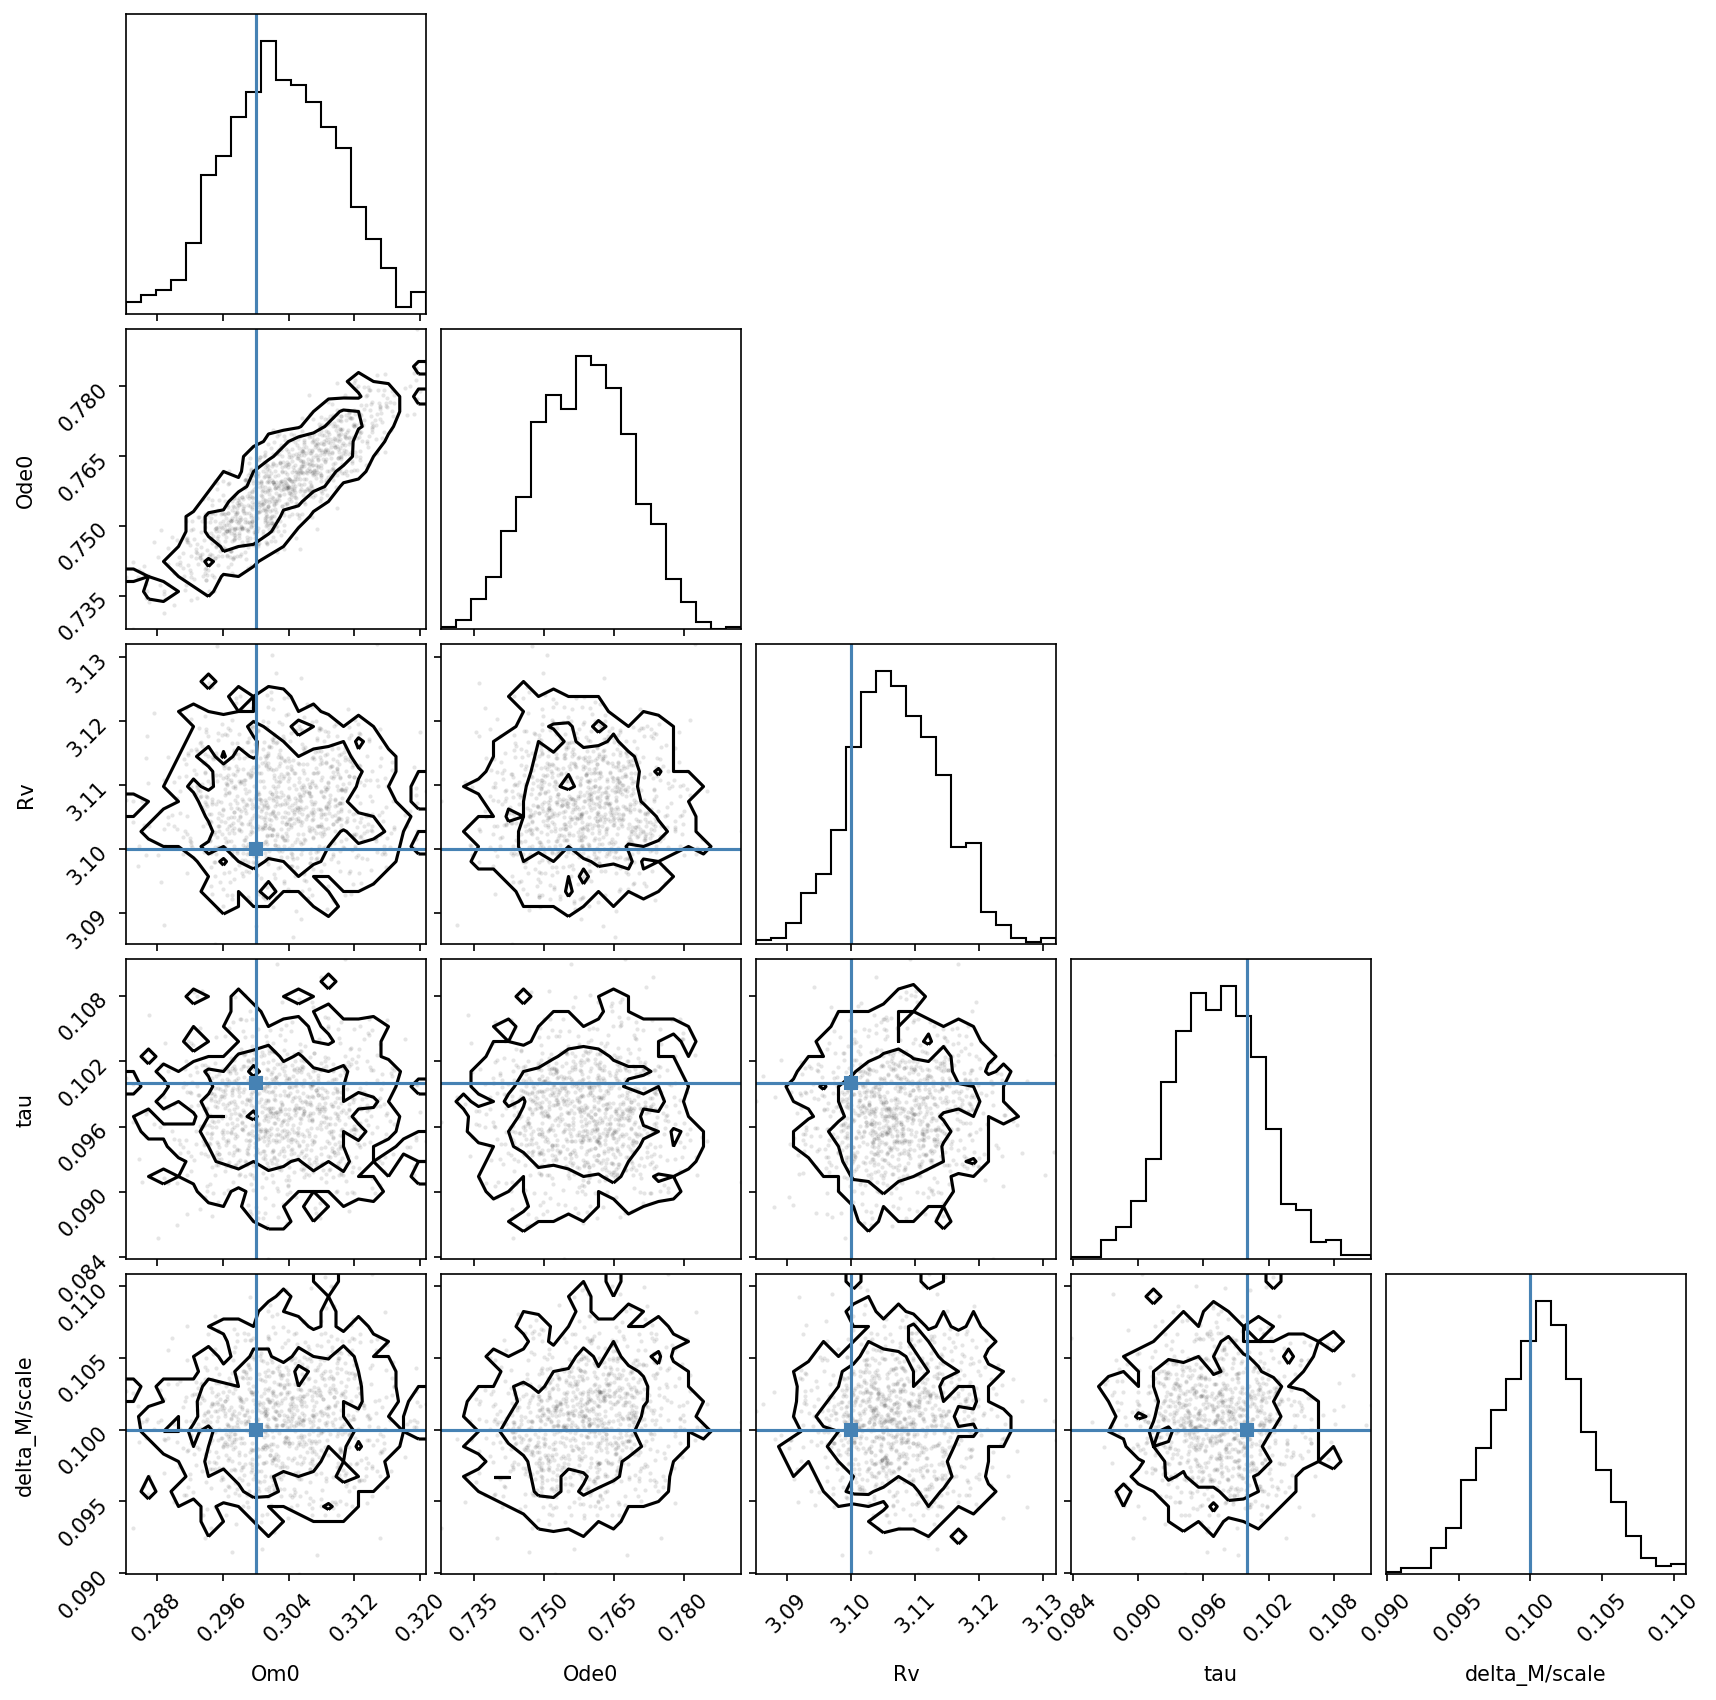

In [16]:
from operator import itemgetter
from corner import corner

corner(dict(zip(names_full, itemgetter(*names_full)(ppd))), truths=truths, levels=(0.68, 0.95), plot_density=False, no_fill_contours=True);
if DOSAVE:
    plt.savefig(f'res-{DATA_GEN}/plots/{SAVENAME}-g.png')

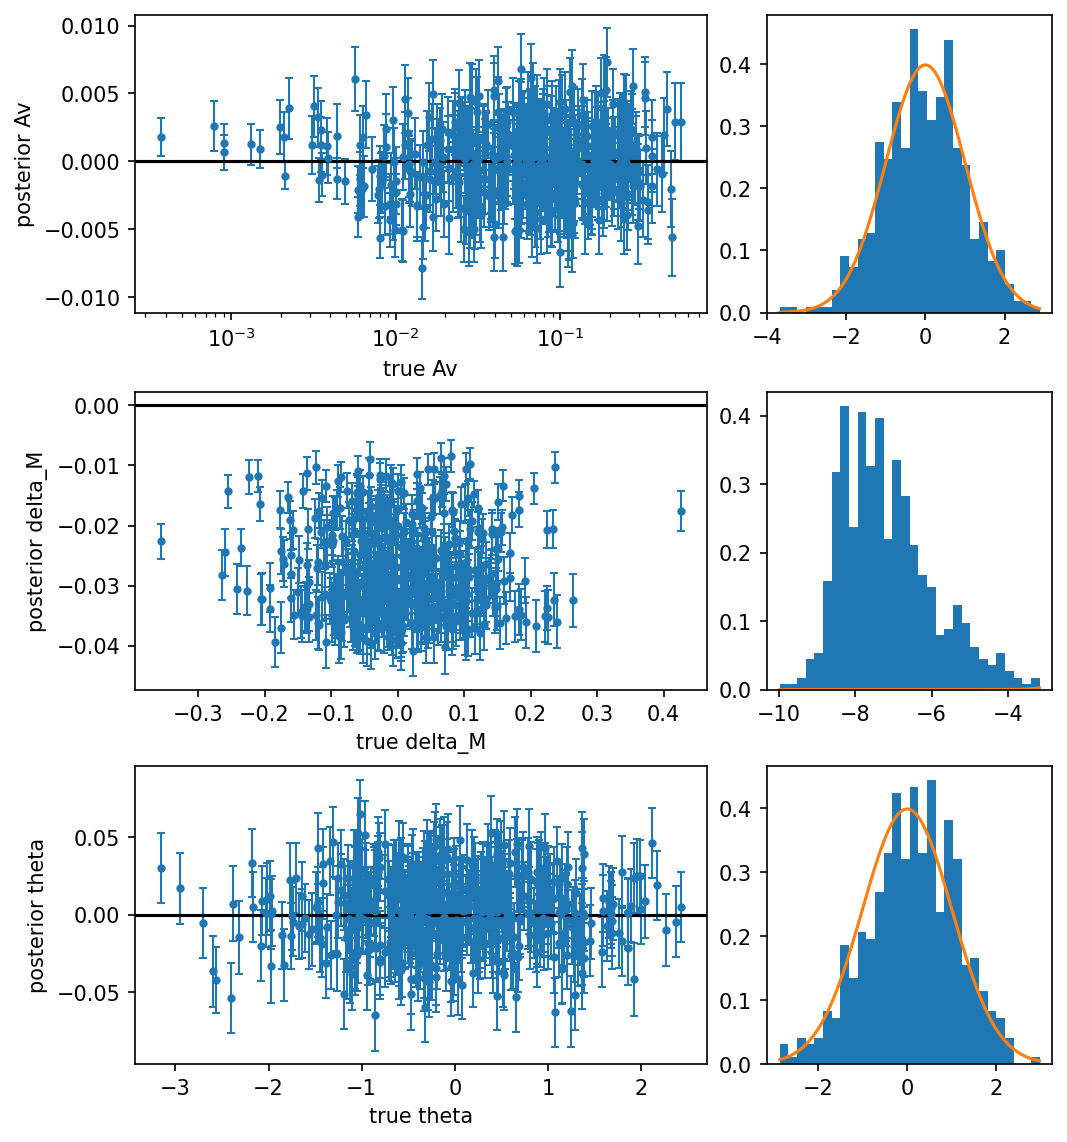

In [17]:
from itertools import repeat


trues, means, stds, errs = map(dict, zip(*(
    zip(repeat(name), (true, mean, val.std(0), mean - true))
    for name in names_hier
    for val in [ppd[name].squeeze(-1)]
    for true in [truths[name].squeeze()]
    for mean in [val.mean(0)]
)))

fig, axs = plt.subplots(len(names_hier), 2, figsize=(7, len(names_hier)*2.5),
                        gridspec_kw=dict(width_ratios=(4, 2)))
for (ax, histax), name in zip(axs, names_hier):
    ax.errorbar(trues[name], errs[name], stds[name],
                ls='none', marker='.', elinewidth=1, capthick=1, capsize=2)
    ax.set_xlabel(f'true {name}')
    ax.set_ylabel(f'posterior {name}')
    ax.axhline(0, color='k')

    histax.hist((nerr := errs[name]/stds[name]).numpy(), density=True, bins=30)
    histax.plot(x := torch.linspace(nerr.min().item(), nerr.max().item(), 101), (-x**2/2).exp() / (2*pi)**0.5)
axs[0, 0].semilogx();
if DOSAVE:
    plt.savefig(f'res-{DATA_GEN}/plots/{SAVENAME}-SN.png')

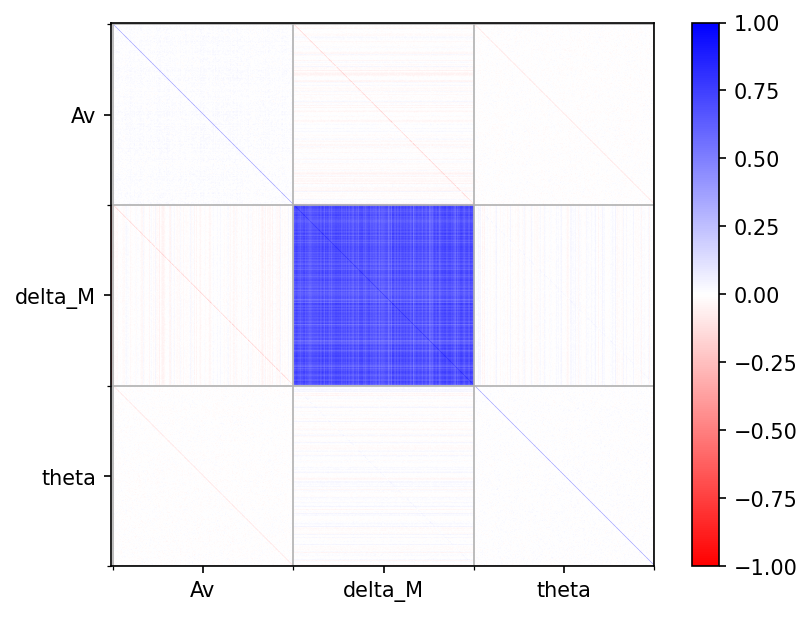

In [18]:
plt.imshow(C, extent=2*(-nfull-0.5, nhier*N-0.5), vmin=-1, vmax=1, cmap='bwr_r',
           origin='lower')
plt.gca().invert_yaxis()
plt.colorbar()


ax = plt.gca()
plt.xticks(range(N//2, nhier*N+1, N), names_hier)
ax.set_xticks(range(0, nhier*N+1, N), minor=True)

plt.yticks(range(N//2, nhier*N+1, N), names_hier)
ax.set_yticks(range(0, nhier*N+1, N), minor=True)

plt.grid(which='minor')
if DOSAVE:
    plt.savefig(f'res-{DATA_GEN}/plots/{SAVENAME}-C.png')

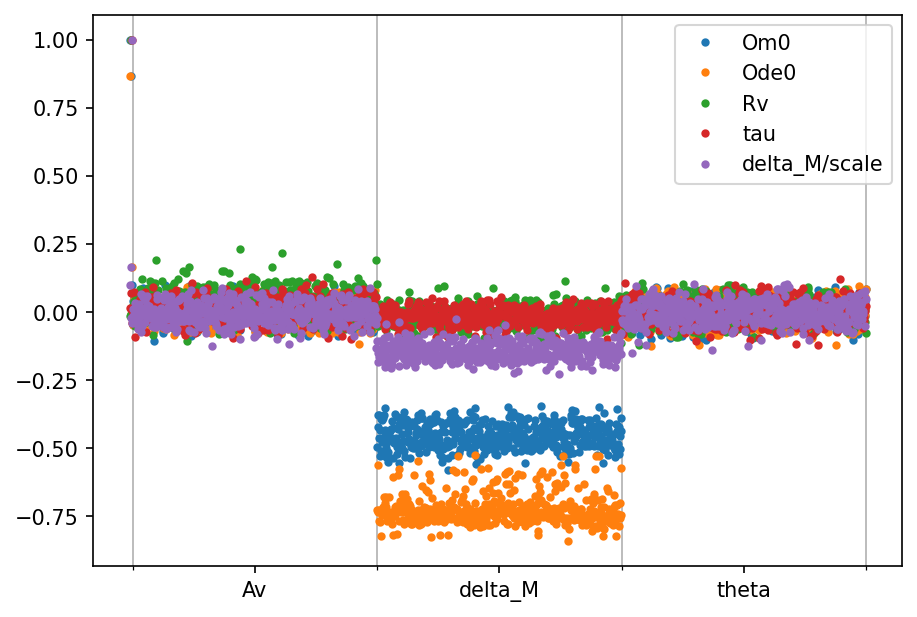

In [19]:
for c, name in zip(C, names_full):
    plt.plot(range(-nfull, nhier*N), c, '.', label=name, lw=1)
plt.legend()
ax = plt.gca()
plt.xticks(range(N//2, nhier*N+1, N), names_hier)
ax.set_xticks(range(0, nhier*N+1, N), minor=True)
plt.grid(which='minor')
if DOSAVE:
    plt.savefig(f'res-{DATA_GEN}/plots/{SAVENAME}-Ccross.png')

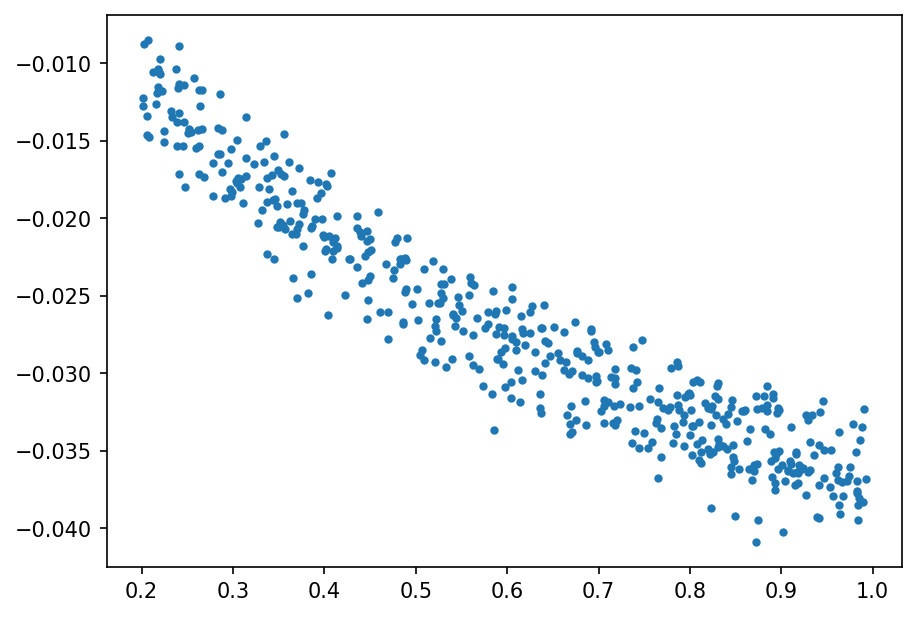

In [13]:
plt.plot(truths['z_cosmo'], errs['delta_M'], '.');

Text(0.5, 0, 'normalised residual of observation')

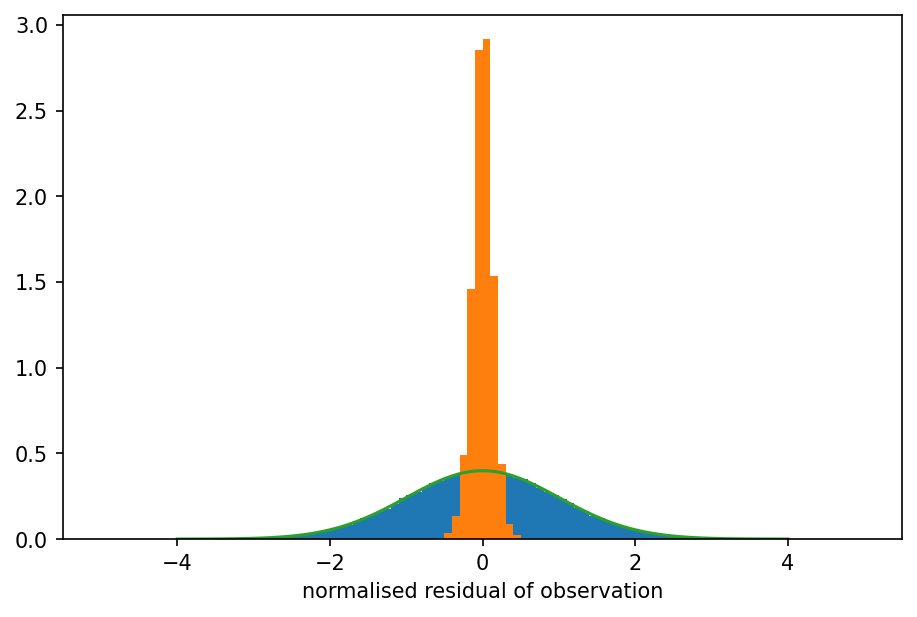

In [14]:
model_trace = config.ppd(conditioning=True)['model_trace']

for tt in (trace.nodes['obs']['value'],
           trace.nodes['obs']['fn'].base_dist.loc):
    plt.hist(
        ((model_trace.nodes['obs']['fn'].base_dist.loc - tt) / 0.02).flatten().numpy(),
        density=True, bins=100, range=(-5, 5))

plt.plot(x := torch.linspace(-4, 4, 101), (-x**2/2).exp() / (2*pi)**0.5)
plt.xlabel('normalised residual of observation')

### Generate mock data

In [2]:
with pyro.condition(data={'Rv': 3.1, 'tau': 0.1, 'delta_M/scale': 0.1}):
    trace = config.mock()
# _trace, trace = trace, model_trace
print(trace.nodes['Rv']['value'], trace.nodes['tau']['value'], trace.nodes['delta_M/scale']['value'],
      trace.nodes['Om0']['value'], trace.nodes['Ode0']['value'])
res = trace.nodes['obs']['value']
ress = [res[..., i:i+len(times)] for i in range(0, len(lc.field.times), len(times))]

3.1 0.1 0.1 tensor(0.3000) tensor(0.7000)


/home/kosio/Projects/Python/pyrofit-utils/pyrofit/utils/interpolate/abc.py:34: UserWarning: input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible (Triggered internally at  /build/python-pytorch/src/pytorch-1.9.1-opt-cuda/aten/src/ATen/native/BucketizationUtils.h:19.)
  return searchsorted(*broadcast_except(grid, x, dim=-1), right=True).clamp_(1, grid.shape[-1]-1).sub_(1)


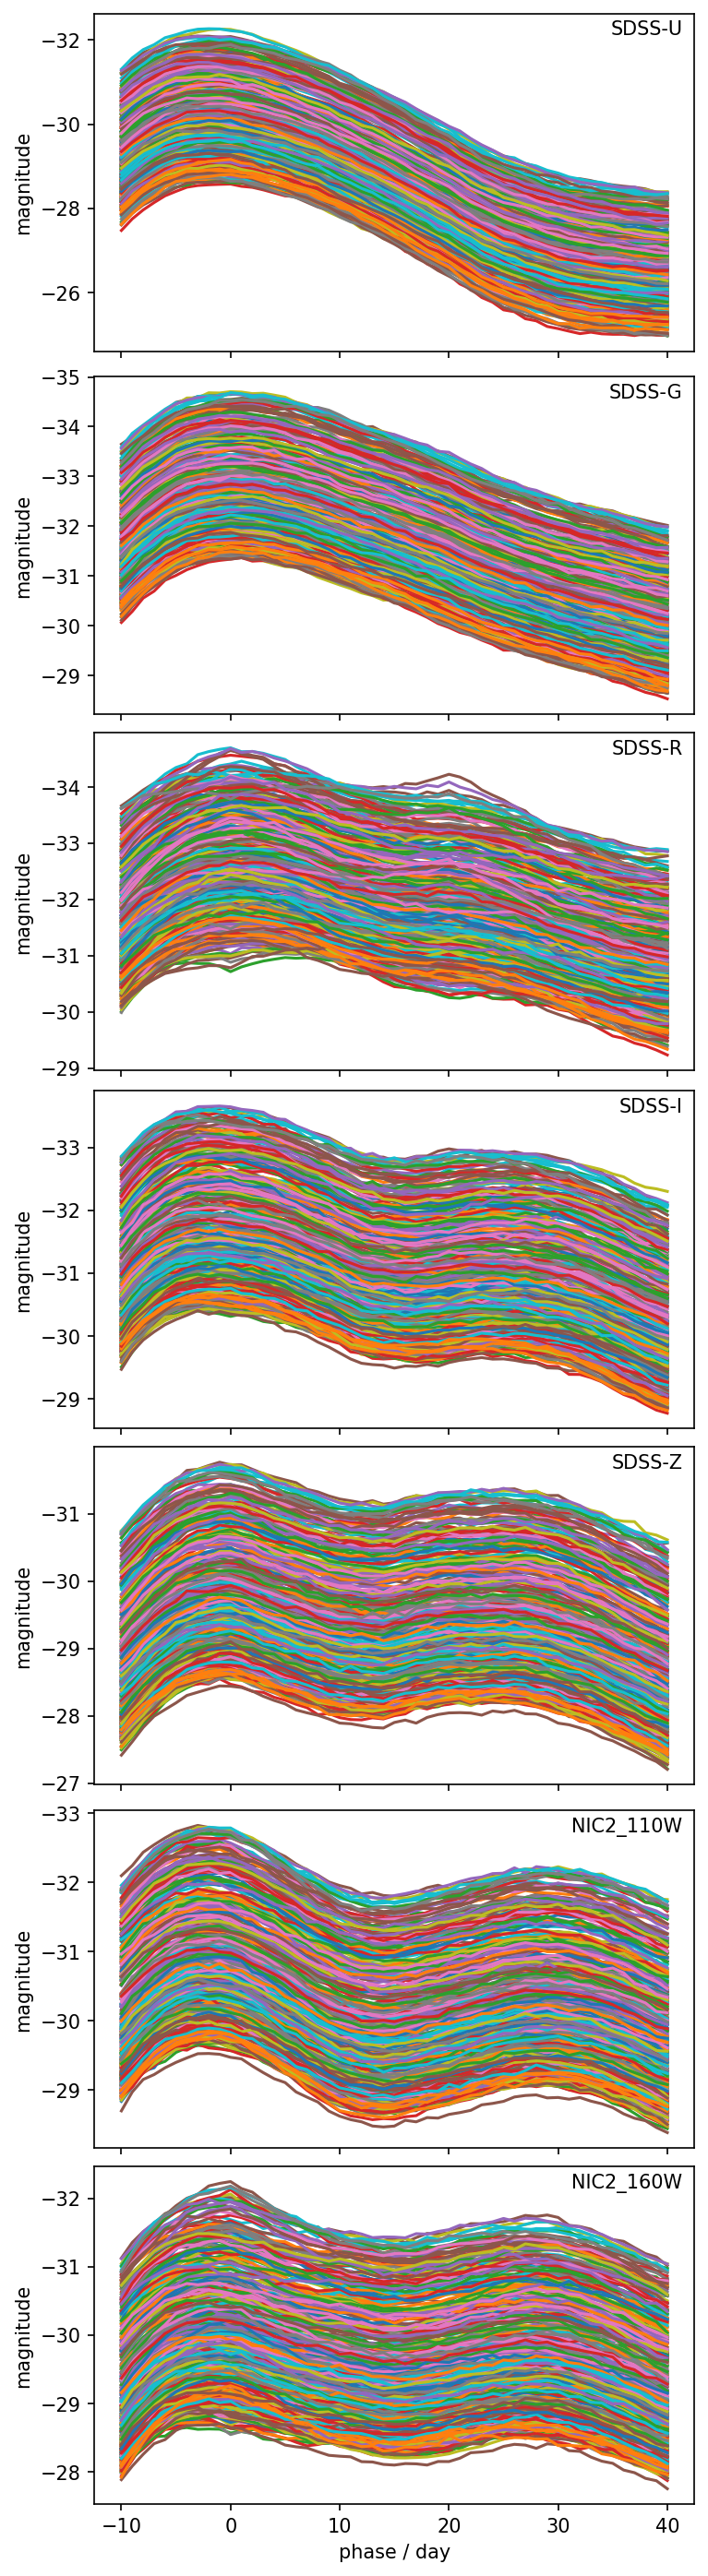

In [3]:
fig, axs = plt.subplots(len(filters), 1, sharex='col', figsize=(5, len(filters)*2.5+1))
for ax, r, band in zip(axs, ress, ('SDSS-U', 'SDSS-G', 'SDSS-R', 'SDSS-I', 'SDSS-Z', 'NIC2_110W', 'NIC2_160W')):
    ax.plot(times, r.T)
    ax.invert_yaxis()
    ax.text(0.98, 0.98, band,
            transform=ax.transAxes, ha='right', va='top')
    ax.set_ylabel('magnitude')
axs[-1].set_xlabel('phase / day');
# trace = _trace